# Fine Tuning Sentiment Analysis

In [64]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoConfig, TrainingArguments, AutoModelForSequenceClassification, Trainer, pipeline
from torchinfo import summary
import json
import evaluate
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
# load the glue dataset specialized in sentiment analysis sst2
raw_datasets = load_dataset('glue', 'sst2') 

# try with "amazon_polarity" dataset

In [3]:
raw_datasets
# get a list of the methods available on a dataset
# dir(raw_datasets['train'])
# get the path of the documentation
# type(raw_datasets['train'])


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

we can index the data set with a range of indices, just like a list.

We can also get the name of the classes Ids, with the features method

In [4]:
print(raw_datasets['train'][10:13])
print(raw_datasets['train'].features)

{'sentence': ['goes to absurd lengths ', "for those moviegoers who complain that ` they do n't make movies like they used to anymore ", "the part where nothing 's happening , "], 'label': [0, 0, 0], 'idx': [10, 11, 12]}
{'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'positive'], id=None), 'idx': Value(dtype='int32', id=None)}


### Tokenizer

In [5]:
# checkpoint = 'bert-base-uncased'
checkpoint = 'distilbert-base-uncased' # trains faster
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [6]:
tokenized_sentences = tokenizer(raw_datasets['train'][0:3]['sentence'], truncation=True)
from pprint import pprint
pprint(tokenized_sentences)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 102],
               [101,
                3397,
                2053,
                15966,
                1010,
                2069,
                4450,
                2098,
                18201,
                2015,
                102],
               [101,
                2008,
                7459,
                2049,
                3494,
                1998,
                10639,
                2015,
                2242,
                2738,
                3376,
                2055,
                2529,
                3267,
                102]]}


In [7]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [8]:
tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map: 100%|██████████| 67349/67349 [00:00<00:00, 69985.77 examples/s]


### Training Arguments

In [12]:
training_args = TrainingArguments(
  'sentiment_analysis_trainer',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=1,
)

### Model

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors: 100%|██████████| 268M/268M [00:40<00:00, 6.66MB/s] 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
type(model)

transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification

In [17]:
# with torchinfo summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0

Let's save the un-trained parameters in a list so that we can compare after training

In [18]:
params_before = []
for name, p in model.named_parameters():
  params_before.append(p.detach().cpu().numpy())

### Metrics

In [21]:
metric = load_metric('glue', 'sst2')

/var/folders/cv/rf4bgk9d1sqgbjbk5ydbt4740000gn/T/ipykernel_51427/2092214033.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', 'sst2')


In [24]:
glue_metric = evaluate.load('glue', 'sst2')

In [25]:
print(metric.compute(predictions=[1, 0, 1], references=[1, 0, 0]))
print(glue_metric.compute(predictions=[1, 0, 1], references=[1, 0, 0]))

{'accuracy': 0.6666666666666666}
{'accuracy': 0.6666666666666666}


we have to create this function to match the Trainer API

In [26]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  return glue_metric.compute(predictions=predictions, references=labels)

### Trainer

In [27]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [28]:
trainer.train()

  6%|▌         | 501/8419 [01:04<13:25,  9.84it/s] 

{'loss': 0.4331, 'learning_rate': 4.7030526190759e-05, 'epoch': 0.06}


 12%|█▏        | 1002/8419 [01:53<11:26, 10.80it/s]

{'loss': 0.3376, 'learning_rate': 4.4061052381518e-05, 'epoch': 0.12}


 18%|█▊        | 1501/8419 [02:42<10:47, 10.69it/s]

{'loss': 0.3399, 'learning_rate': 4.109157857227699e-05, 'epoch': 0.18}


 24%|██▍       | 2001/8419 [03:30<09:57, 10.74it/s]

{'loss': 0.3169, 'learning_rate': 3.812210476303599e-05, 'epoch': 0.24}


 30%|██▉       | 2501/8419 [04:17<09:30, 10.36it/s]

{'loss': 0.2854, 'learning_rate': 3.515263095379499e-05, 'epoch': 0.3}


 36%|███▌      | 3002/8419 [05:05<08:33, 10.54it/s]

{'loss': 0.287, 'learning_rate': 3.218315714455399e-05, 'epoch': 0.36}


 42%|████▏     | 3501/8419 [05:53<07:55, 10.34it/s]

{'loss': 0.2614, 'learning_rate': 2.9213683335312986e-05, 'epoch': 0.42}


 48%|████▊     | 4002/8419 [06:41<06:56, 10.61it/s]

{'loss': 0.2566, 'learning_rate': 2.6244209526071984e-05, 'epoch': 0.48}


 53%|█████▎    | 4501/8419 [07:28<06:05, 10.72it/s]

{'loss': 0.2253, 'learning_rate': 2.3274735716830978e-05, 'epoch': 0.53}


 59%|█████▉    | 5001/8419 [08:15<05:29, 10.36it/s]

{'loss': 0.2427, 'learning_rate': 2.0305261907589976e-05, 'epoch': 0.59}


 65%|██████▌   | 5501/8419 [09:03<04:28, 10.88it/s]

{'loss': 0.24, 'learning_rate': 1.7335788098348973e-05, 'epoch': 0.65}


 71%|███████▏  | 6001/8419 [09:50<03:53, 10.37it/s]

{'loss': 0.2152, 'learning_rate': 1.4366314289107971e-05, 'epoch': 0.71}


 77%|███████▋  | 6501/8419 [10:37<03:00, 10.60it/s]

{'loss': 0.2189, 'learning_rate': 1.1396840479866969e-05, 'epoch': 0.77}


 83%|████████▎ | 7002/8419 [12:25<02:16, 10.42it/s]  

{'loss': 0.2222, 'learning_rate': 8.427366670625965e-06, 'epoch': 0.83}


 89%|████████▉ | 7501/8419 [13:13<01:28, 10.39it/s]

{'loss': 0.205, 'learning_rate': 5.457892861384962e-06, 'epoch': 0.89}


 95%|█████████▌| 8001/8419 [14:01<00:40, 10.29it/s]

{'loss': 0.2141, 'learning_rate': 2.4884190521439603e-06, 'epoch': 0.95}


                                                   
100%|██████████| 8419/8419 [14:47<00:00,  4.39it/s]

{'eval_loss': 0.35671108961105347, 'eval_accuracy': 0.9048165137614679, 'eval_runtime': 4.4444, 'eval_samples_per_second': 196.203, 'eval_steps_per_second': 24.525, 'epoch': 1.0}


100%|██████████| 8419/8419 [14:49<00:00,  9.47it/s]

{'train_runtime': 889.0206, 'train_samples_per_second': 75.756, 'train_steps_per_second': 9.47, 'train_loss': 0.2665088724702055, 'epoch': 1.0}


TrainOutput(global_step=8419, training_loss=0.2665088724702055, metrics={'train_runtime': 889.0206, 'train_samples_per_second': 75.756, 'train_steps_per_second': 9.47, 'train_loss': 0.2665088724702055, 'epoch': 1.0})

In [29]:
trainer.save_model('fine_tuned_sentiment_analysis_model')

In [32]:
newmodel = pipeline('text-classification', model='fine_tuned_sentiment_analysis_model', device='mps')

In [33]:
print(newmodel('This movie is great!'))
print(newmodel('This movie is definitely not the best one I have seen lately!'))

[{'label': 'LABEL_1', 'score': 0.9988316893577576}]
[{'label': 'LABEL_0', 'score': 0.9944121241569519}]


Modify the config.json file of the model so that we give names to labels

In [34]:
config_path = 'fine_tuned_sentiment_analysis_model/config.json'
with open(config_path) as f:
  j = json.load(f)

j['id2label'] = {0: 'negative', 1: 'positive'}

with open(config_path, 'w') as f:
  json.dump(j, f, indent=2)

Reload the model

In [36]:
newmodel = pipeline('text-classification', model='fine_tuned_sentiment_analysis_model', device='mps')

In [37]:
newmodel('This movie is great!')

[{'label': 'positive', 'score': 0.9988316893577576}]

### Compare the model's parameters before and after training

In [39]:
params_after = []
for name, p in model.named_parameters():
  params_after.append(p.detach().cpu().numpy())

In [40]:
# verify that the params have changed
for p1, p2 in zip(params_before, params_after):
  print(np.sum(np.abs(p1 - p2)))

13300.65
89.88836
1.7955394
1.1239388
1297.5863
1.7593204
1288.6768
0.003140492
1196.1934
1.0895162
1132.2045
0.84817284
1.6469915
0.8338374
4953.178
5.767476
4541.567
0.69504136
1.5693657
0.7349802
1282.287
1.421695
1277.6827
0.0033160353
1129.1239
0.8821959
1077.76
0.7430595
1.524674
0.73176754
4924.571
5.45126
4496.398
0.7148503
1.5088928
0.80420995
1275.1122
1.504866
1299.787
0.0026822262
1142.9791
0.8354318
1119.2639
0.71764046
1.5220361
0.77335036
4983.0083
5.5937324
4477.8286
0.74410963
1.3862755
0.79971766
1310.8688
1.5094472
1323.6318
0.003470317
1178.9724
0.8257409
1130.1505
0.8058703
1.4013195
0.78627086
4879.233
5.4010105
4265.6304
0.7887438
1.3308091
0.8252969
1200.4796
1.6016853
1191.1804
0.002376105
998.4962
0.78034025
1006.103
0.90565497
1.4091291
0.94643724
4442.6836
5.0295005
3520.7502
0.7151392
1.3262099
0.7596569
1107.5911
1.1820103
1130.9719
0.001162499
920.14825
0.88509226
900.5255
1.1747687
1.3468661
1.1817567
3555.3335
4.628983
3045.2712
0.8681102
1.2758484
0.67

# Fine tune with a custom dataset

In [2]:
df_ = pd.read_csv('../../datasets/tweets/AirlineTweets.csv')
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df = df_[['airline_sentiment', 'text']].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

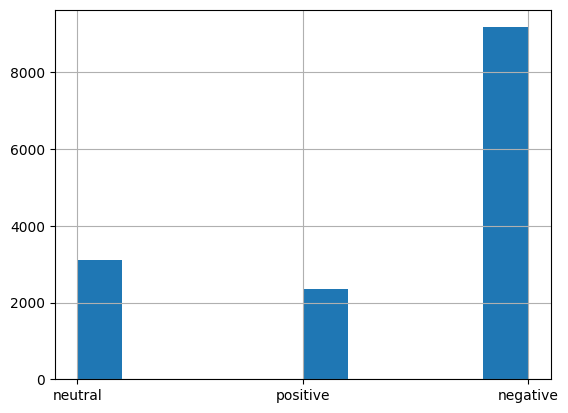

In [4]:
df['airline_sentiment'].hist()

In [5]:
target_map = {'negative': 0, 'positive': 1, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

Format the the df like the huggingface datasets

In [6]:
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label']
df2.to_csv('airlines_tweet_data.csv', index=None)

Load new dataset with hugging face library

In [7]:
# if you have multiple csv files
# load_dataset('csv', data_files=['file1.csv', 'file2.csv'])

# if you already have a train-test split:
# load_dataset(
#     'csv',
#     data_files={'train': ['train1.csv', 'train2.csv'],
#                 'test': 'test.csv'
#     }
# )

raw_dataset = load_dataset('csv', data_files='airlines_tweet_data.csv')

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 576.46it/s]
Generating train split: 0 examples [00:00, ? examples/s]/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
Generating train split: 14640 examples [00:00, 411349.52 examples/s]


In [8]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [9]:
split = raw_dataset['train'].train_test_split(test_size=0.25, seed=42)

### Now that we have our dataset, we can focus on the model now

In [10]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

(…)cased/resolve/main/tokenizer_config.json: 100%|██████████| 29.0/29.0 [00:00<00:00, 25.2kB/s]
(…)bert-base-cased/resolve/main/config.json: 100%|██████████| 465/465 [00:00<00:00, 2.09MB/s]
(…)ilbert-base-cased/resolve/main/vocab.txt: 100%|██████████| 213k/213k [00:01<00:00, 181kB/s]
(…)t-base-cased/resolve/main/tokenizer.json: 100%|██████████| 436k/436k [00:01<00:00, 387kB/s]


In [11]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

tokenized_datasets = split.map(tokenize_fn, batched=True)

Map: 100%|██████████| 3660/3660 [00:00<00:00, 42452.35 examples/s]


#### Use AutoConfig to specify the labels of the model

In [65]:
config = AutoConfig.from_pretrained(checkpoint)

In [66]:
print(config.id2label)
print(config.label2id)

{0: 'LABEL_0', 1: 'LABEL_1'}
{'LABEL_0': 0, 'LABEL_1': 1}


In [68]:
config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map
print(config.id2label)
print(config.label2id)

{1: 'positive', 0: 'negative', 2: 'neutral'}
{'positive': 1, 'negative': 0, 'neutral': 2}


In [70]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [72]:
training_args = TrainingArguments(
  output_dir='sentiment_analysis_trainer',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=3,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

In [73]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [74]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [75]:
trainer.train()

 24%|██▍       | 501/2061 [00:56<03:08,  8.30it/s]

{'loss': 0.5457, 'learning_rate': 3.78699660359049e-05, 'epoch': 0.73}


                                                  
 33%|███▎      | 687/2061 [01:23<03:40,  6.22it/s]

{'eval_loss': 0.4685932397842407, 'eval_accuracy': 0.8248633879781421, 'eval_f1': 0.7515352142350925, 'eval_runtime': 5.556, 'eval_samples_per_second': 658.743, 'eval_steps_per_second': 10.439, 'epoch': 1.0}


 49%|████▊     | 1001/2061 [02:00<02:06,  8.38it/s]

{'loss': 0.3776, 'learning_rate': 2.57399320718098e-05, 'epoch': 1.46}


                                                   
 67%|██████▋   | 1374/2061 [02:49<01:17,  8.88it/s]

{'eval_loss': 0.4904250204563141, 'eval_accuracy': 0.8360655737704918, 'eval_f1': 0.7876409201287684, 'eval_runtime': 5.2073, 'eval_samples_per_second': 702.858, 'eval_steps_per_second': 11.138, 'epoch': 2.0}


 73%|███████▎  | 1501/2061 [03:04<01:05,  8.61it/s]

{'loss': 0.272, 'learning_rate': 1.3609898107714703e-05, 'epoch': 2.18}


 97%|█████████▋| 2001/2061 [04:03<00:09,  6.27it/s]

{'loss': 0.1809, 'learning_rate': 1.4798641436196021e-06, 'epoch': 2.91}


                                                   
100%|██████████| 2061/2061 [04:16<00:00,  8.56it/s]

{'eval_loss': 0.6055350303649902, 'eval_accuracy': 0.8371584699453551, 'eval_f1': 0.783973185053759, 'eval_runtime': 5.2783, 'eval_samples_per_second': 693.405, 'eval_steps_per_second': 10.988, 'epoch': 3.0}


100%|██████████| 2061/2061 [04:17<00:00,  8.01it/s]

{'train_runtime': 257.4184, 'train_samples_per_second': 127.963, 'train_steps_per_second': 8.006, 'train_loss': 0.3385036251950993, 'epoch': 3.0}


TrainOutput(global_step=2061, training_loss=0.3385036251950993, metrics={'train_runtime': 257.4184, 'train_samples_per_second': 127.963, 'train_steps_per_second': 8.006, 'train_loss': 0.3385036251950993, 'epoch': 3.0})

Load the model that we just trained from the trainer folder

In [76]:
savedmodel = pipeline('text-classification',
                      model='sentiment_analysis_trainer/checkpoint-2061',
                      device='mps')

Test on the test set

In [77]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 3660
})

In [78]:
test_pred = savedmodel(split['test']['sentence'])

In [79]:
test_pred[0:3]

[{'label': 'positive', 'score': 0.9645380973815918},
 {'label': 'positive', 'score': 0.97712641954422},
 {'label': 'neutral', 'score': 0.7297358512878418}]

In [80]:
# def get_label(d):
#   return int(d['label'].split('_')[1])

test_pred = [d['label'] for d in test_pred]

In [81]:
test_pred[0:3]

['positive', 'positive', 'neutral']

In [82]:
test_labels = [config.id2label[x] for x in split['test']['label']]
test_labels[0:3]

['positive', 'positive', 'neutral']

In [83]:
print("acc:", accuracy_score(test_labels, test_pred))
print("f1-score:", f1_score(test_labels, test_pred, average='macro'))

acc: 0.8371584699453551
f1-score: 0.783973185053759


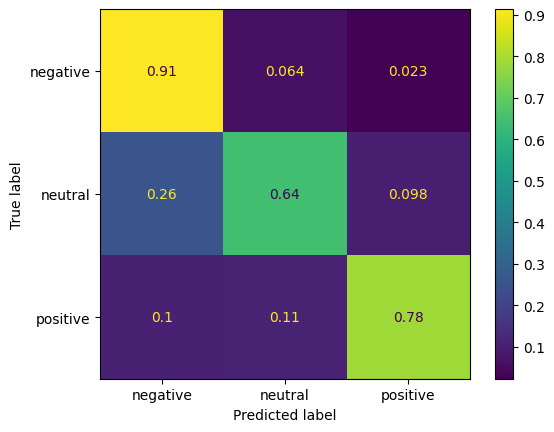

In [86]:
cm = confusion_matrix(test_labels, test_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot()